In [33]:
#https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/ code from here
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import string
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk

In [34]:
# nltk.download()

In [35]:
#Read the data
hoax_data =pd.read_csv('clean_hoax.csv')
real_data = pd.read_csv('clean_real.csv')
hoax_data['label']=['False']*len(hoax_data)
real_data['label']=['True']*len(real_data)

df=hoax_data.append(real_data).sample(frac=1).reset_index().drop(columns=['index'])
df

,title_name,label
0,"“Sekeluarga Kena Corona, Tinggal di Bintaro S...",False
1,Masker LG PuriCare Generasi Terbaru Lebih Ring...,True
2,"Kabar Mengejutkan Deddy Corbuzier, Sempat Krit...",True
3,"WNI Bisa Masuk Singapura Lagi, Nih Mulai Pekan...",True
4,"WFO Kini 75 Persen, Ini Aturan Lengkap PPKM Le...",True
...,...,...
8270,Jokowi Mau Kumpulkan Gubernur hingga Walikota ...,True
8271,"Terapi Cuci Hidung Penting di Masa Pandemi, Be...",True
8272,"“Covid-19 BUKAN Virus, Sumber : Kementerian K...",False
8273,Geger Kematian Perdana Akibat Varian Omicron,True


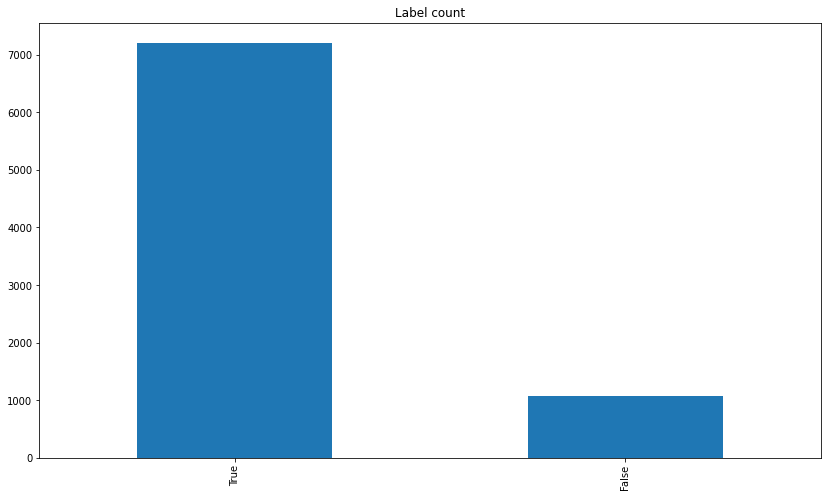

In [36]:
ax = df['label'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Label count")

In [37]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
df['clean_msg']= df['title_name'].apply(lambda x:remove_punctuation(x))
df.head()

,title_name,label,clean_msg
0,"“Sekeluarga Kena Corona, Tinggal di Bintaro S...",False,“Sekeluarga Kena Corona Tinggal di Bintaro Se...
1,Masker LG PuriCare Generasi Terbaru Lebih Ring...,True,Masker LG PuriCare Generasi Terbaru Lebih Ring...
2,"Kabar Mengejutkan Deddy Corbuzier, Sempat Krit...",True,Kabar Mengejutkan Deddy Corbuzier Sempat Kriti...
3,"WNI Bisa Masuk Singapura Lagi, Nih Mulai Pekan...",True,WNI Bisa Masuk Singapura Lagi Nih Mulai Pekan ...
4,"WFO Kini 75 Persen, Ini Aturan Lengkap PPKM Le...",True,WFO Kini 75 Persen Ini Aturan Lengkap PPKM Lev...


In [38]:
df['msg_lower']= df['clean_msg'].apply(lambda x: x.lower())
df

,title_name,label,clean_msg,msg_lower
0,"“Sekeluarga Kena Corona, Tinggal di Bintaro S...",False,“Sekeluarga Kena Corona Tinggal di Bintaro Se...,“sekeluarga kena corona tinggal di bintaro se...
1,Masker LG PuriCare Generasi Terbaru Lebih Ring...,True,Masker LG PuriCare Generasi Terbaru Lebih Ring...,masker lg puricare generasi terbaru lebih ring...
2,"Kabar Mengejutkan Deddy Corbuzier, Sempat Krit...",True,Kabar Mengejutkan Deddy Corbuzier Sempat Kriti...,kabar mengejutkan deddy corbuzier sempat kriti...
3,"WNI Bisa Masuk Singapura Lagi, Nih Mulai Pekan...",True,WNI Bisa Masuk Singapura Lagi Nih Mulai Pekan ...,wni bisa masuk singapura lagi nih mulai pekan ...
4,"WFO Kini 75 Persen, Ini Aturan Lengkap PPKM Le...",True,WFO Kini 75 Persen Ini Aturan Lengkap PPKM Lev...,wfo kini 75 persen ini aturan lengkap ppkm lev...
...,...,...,...,...
8270,Jokowi Mau Kumpulkan Gubernur hingga Walikota ...,True,Jokowi Mau Kumpulkan Gubernur hingga Walikota ...,jokowi mau kumpulkan gubernur hingga walikota ...
8271,"Terapi Cuci Hidung Penting di Masa Pandemi, Be...",True,Terapi Cuci Hidung Penting di Masa Pandemi Beg...,terapi cuci hidung penting di masa pandemi beg...
8272,"“Covid-19 BUKAN Virus, Sumber : Kementerian K...",False,“Covid19 BUKAN Virus Sumber Kementerian Kese...,“covid19 bukan virus sumber kementerian kese...
8273,Geger Kematian Perdana Akibat Varian Omicron,True,Geger Kematian Perdana Akibat Varian Omicron,geger kematian perdana akibat varian omicron


In [39]:
#defining function for tokenization
import re
def tokenization(text):
    tokens = re.split('\W+',text)
    while("" in tokens) :
        tokens.remove("")
    return tokens

def freqword(token):
    freq_tokens = nltk.FreqDist(token)
    return freq_tokens.most_common()
#applying function to the column
df['msg_tokenized']= df['msg_lower'].apply(lambda x: tokenization(x))
df['msg_tokenize_freq']= df['msg_tokenized'].apply(lambda x: freqword(x))
df.head()


,title_name,label,clean_msg,msg_lower,msg_tokenized,msg_tokenize_freq
0,"“Sekeluarga Kena Corona, Tinggal di Bintaro S...",False,“Sekeluarga Kena Corona Tinggal di Bintaro Se...,“sekeluarga kena corona tinggal di bintaro se...,"[sekeluarga, kena, corona, tinggal, di, bintar...","[(sekeluarga, 1), (kena, 1), (corona, 1), (tin..."
1,Masker LG PuriCare Generasi Terbaru Lebih Ring...,True,Masker LG PuriCare Generasi Terbaru Lebih Ring...,masker lg puricare generasi terbaru lebih ring...,"[masker, lg, puricare, generasi, terbaru, lebi...","[(masker, 1), (lg, 1), (puricare, 1), (generas..."
2,"Kabar Mengejutkan Deddy Corbuzier, Sempat Krit...",True,Kabar Mengejutkan Deddy Corbuzier Sempat Kriti...,kabar mengejutkan deddy corbuzier sempat kriti...,"[kabar, mengejutkan, deddy, corbuzier, sempat,...","[(kabar, 1), (mengejutkan, 1), (deddy, 1), (co..."
3,"WNI Bisa Masuk Singapura Lagi, Nih Mulai Pekan...",True,WNI Bisa Masuk Singapura Lagi Nih Mulai Pekan ...,wni bisa masuk singapura lagi nih mulai pekan ...,"[wni, bisa, masuk, singapura, lagi, nih, mulai...","[(wni, 1), (bisa, 1), (masuk, 1), (singapura, ..."
4,"WFO Kini 75 Persen, Ini Aturan Lengkap PPKM Le...",True,WFO Kini 75 Persen Ini Aturan Lengkap PPKM Lev...,wfo kini 75 persen ini aturan lengkap ppkm lev...,"[wfo, kini, 75, persen, ini, aturan, lengkap, ...","[(wfo, 1), (kini, 1), (75, 1), (persen, 1), (i..."


In [40]:
from nltk.corpus import stopwords
list_stopwords = set(stopwords.words('indonesian'))
def remove_stopwords(text):
    output= [i for i in text if i not in list_stopwords]
    return output
df['no_stopwords']= df['msg_tokenized'].apply(lambda x:remove_stopwords(x))
df


,title_name,label,clean_msg,msg_lower,msg_tokenized,msg_tokenize_freq,no_stopwords
0,"“Sekeluarga Kena Corona, Tinggal di Bintaro S...",False,“Sekeluarga Kena Corona Tinggal di Bintaro Se...,“sekeluarga kena corona tinggal di bintaro se...,"[sekeluarga, kena, corona, tinggal, di, bintar...","[(sekeluarga, 1), (kena, 1), (corona, 1), (tin...","[sekeluarga, kena, corona, tinggal, bintaro, s..."
1,Masker LG PuriCare Generasi Terbaru Lebih Ring...,True,Masker LG PuriCare Generasi Terbaru Lebih Ring...,masker lg puricare generasi terbaru lebih ring...,"[masker, lg, puricare, generasi, terbaru, lebi...","[(masker, 1), (lg, 1), (puricare, 1), (generas...","[masker, lg, puricare, generasi, terbaru, ring..."
2,"Kabar Mengejutkan Deddy Corbuzier, Sempat Krit...",True,Kabar Mengejutkan Deddy Corbuzier Sempat Kriti...,kabar mengejutkan deddy corbuzier sempat kriti...,"[kabar, mengejutkan, deddy, corbuzier, sempat,...","[(kabar, 1), (mengejutkan, 1), (deddy, 1), (co...","[kabar, mengejutkan, deddy, corbuzier, kritish..."
3,"WNI Bisa Masuk Singapura Lagi, Nih Mulai Pekan...",True,WNI Bisa Masuk Singapura Lagi Nih Mulai Pekan ...,wni bisa masuk singapura lagi nih mulai pekan ...,"[wni, bisa, masuk, singapura, lagi, nih, mulai...","[(wni, 1), (bisa, 1), (masuk, 1), (singapura, ...","[wni, masuk, singapura, nih, pekan]"
4,"WFO Kini 75 Persen, Ini Aturan Lengkap PPKM Le...",True,WFO Kini 75 Persen Ini Aturan Lengkap PPKM Lev...,wfo kini 75 persen ini aturan lengkap ppkm lev...,"[wfo, kini, 75, persen, ini, aturan, lengkap, ...","[(wfo, 1), (kini, 1), (75, 1), (persen, 1), (i...","[wfo, 75, persen, aturan, lengkap, ppkm, level..."
...,...,...,...,...,...,...,...
8270,Jokowi Mau Kumpulkan Gubernur hingga Walikota ...,True,Jokowi Mau Kumpulkan Gubernur hingga Walikota ...,jokowi mau kumpulkan gubernur hingga walikota ...,"[jokowi, mau, kumpulkan, gubernur, hingga, wal...","[(jokowi, 1), (mau, 1), (kumpulkan, 1), (guber...","[jokowi, kumpulkan, gubernur, walikota, sore]"
8271,"Terapi Cuci Hidung Penting di Masa Pandemi, Be...",True,Terapi Cuci Hidung Penting di Masa Pandemi Beg...,terapi cuci hidung penting di masa pandemi beg...,"[terapi, cuci, hidung, penting, di, masa, pand...","[(terapi, 1), (cuci, 1), (hidung, 1), (penting...","[terapi, cuci, hidung, pandemi, saran, dokter]"
8272,"“Covid-19 BUKAN Virus, Sumber : Kementerian K...",False,“Covid19 BUKAN Virus Sumber Kementerian Kese...,“covid19 bukan virus sumber kementerian kese...,"[covid19, bukan, virus, sumber, kementerian, k...","[(covid19, 1), (bukan, 1), (virus, 1), (sumber...","[covid19, virus, sumber, kementerian, kesehata..."
8273,Geger Kematian Perdana Akibat Varian Omicron,True,Geger Kematian Perdana Akibat Varian Omicron,geger kematian perdana akibat varian omicron,"[geger, kematian, perdana, akibat, varian, omi...","[(geger, 1), (kematian, 1), (perdana, 1), (aki...","[geger, kematian, perdana, akibat, varian, omi..."


In [41]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()


def stemword(tokens):
    output= [stemmer.stem(token) for token in tokens]
    return output

df['stemword']= df['no_stopwords'].apply(lambda x:stemword(x))
df

,title_name,label,clean_msg,msg_lower,msg_tokenized,msg_tokenize_freq,no_stopwords,stemword
0,"“Sekeluarga Kena Corona, Tinggal di Bintaro S...",False,“Sekeluarga Kena Corona Tinggal di Bintaro Se...,“sekeluarga kena corona tinggal di bintaro se...,"[sekeluarga, kena, corona, tinggal, di, bintar...","[(sekeluarga, 1), (kena, 1), (corona, 1), (tin...","[sekeluarga, kena, corona, tinggal, bintaro, s...","[keluarga, kena, corona, tinggal, bintaro, sek..."
1,Masker LG PuriCare Generasi Terbaru Lebih Ring...,True,Masker LG PuriCare Generasi Terbaru Lebih Ring...,masker lg puricare generasi terbaru lebih ring...,"[masker, lg, puricare, generasi, terbaru, lebi...","[(masker, 1), (lg, 1), (puricare, 1), (generas...","[masker, lg, puricare, generasi, terbaru, ring...","[masker, lg, puricare, generasi, baru, ringan,..."
2,"Kabar Mengejutkan Deddy Corbuzier, Sempat Krit...",True,Kabar Mengejutkan Deddy Corbuzier Sempat Kriti...,kabar mengejutkan deddy corbuzier sempat kriti...,"[kabar, mengejutkan, deddy, corbuzier, sempat,...","[(kabar, 1), (mengejutkan, 1), (deddy, 1), (co...","[kabar, mengejutkan, deddy, corbuzier, kritish...","[kabar, kejut, deddy, corbuzier, kritishampir,..."
3,"WNI Bisa Masuk Singapura Lagi, Nih Mulai Pekan...",True,WNI Bisa Masuk Singapura Lagi Nih Mulai Pekan ...,wni bisa masuk singapura lagi nih mulai pekan ...,"[wni, bisa, masuk, singapura, lagi, nih, mulai...","[(wni, 1), (bisa, 1), (masuk, 1), (singapura, ...","[wni, masuk, singapura, nih, pekan]","[wni, masuk, singapura, nih, pekan]"
4,"WFO Kini 75 Persen, Ini Aturan Lengkap PPKM Le...",True,WFO Kini 75 Persen Ini Aturan Lengkap PPKM Lev...,wfo kini 75 persen ini aturan lengkap ppkm lev...,"[wfo, kini, 75, persen, ini, aturan, lengkap, ...","[(wfo, 1), (kini, 1), (75, 1), (persen, 1), (i...","[wfo, 75, persen, aturan, lengkap, ppkm, level...","[wfo, 75, persen, atur, lengkap, ppkm, level, ..."
...,...,...,...,...,...,...,...,...
8270,Jokowi Mau Kumpulkan Gubernur hingga Walikota ...,True,Jokowi Mau Kumpulkan Gubernur hingga Walikota ...,jokowi mau kumpulkan gubernur hingga walikota ...,"[jokowi, mau, kumpulkan, gubernur, hingga, wal...","[(jokowi, 1), (mau, 1), (kumpulkan, 1), (guber...","[jokowi, kumpulkan, gubernur, walikota, sore]","[jokowi, kumpul, gubernur, walikota, sore]"
8271,"Terapi Cuci Hidung Penting di Masa Pandemi, Be...",True,Terapi Cuci Hidung Penting di Masa Pandemi Beg...,terapi cuci hidung penting di masa pandemi beg...,"[terapi, cuci, hidung, penting, di, masa, pand...","[(terapi, 1), (cuci, 1), (hidung, 1), (penting...","[terapi, cuci, hidung, pandemi, saran, dokter]","[terapi, cuci, hidung, pandemi, saran, dokter]"
8272,"“Covid-19 BUKAN Virus, Sumber : Kementerian K...",False,“Covid19 BUKAN Virus Sumber Kementerian Kese...,“covid19 bukan virus sumber kementerian kese...,"[covid19, bukan, virus, sumber, kementerian, k...","[(covid19, 1), (bukan, 1), (virus, 1), (sumber...","[covid19, virus, sumber, kementerian, kesehata...","[covid19, virus, sumber, menteri, sehat, italy]"
8273,Geger Kematian Perdana Akibat Varian Omicron,True,Geger Kematian Perdana Akibat Varian Omicron,geger kematian perdana akibat varian omicron,"[geger, kematian, perdana, akibat, varian, omi...","[(geger, 1), (kematian, 1), (perdana, 1), (aki...","[geger, kematian, perdana, akibat, varian, omi...","[geger, mati, perdana, akibat, varian, omicron]"


In [42]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(str(texts))
    return ' '.join([text for text in texts])
df["finaltext"] = df["stemword"].apply(join_text_list)
df
df.to_csv('dataset.csv', index=False)